In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/imagesSea.zip -d data

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio('/content/data/imagesSea', output="output", seed=1337, ratio=(.8,0.2))

Copying files: 7550 files [00:04, 1785.43 files/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

cudnn.benchmark - True
plt.ion()

In [ ]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dir = 'output/train'
test_dir = 'output/val'


Train = datasets.ImageFolder(train_dir,data_transforms)

Test = datasets.ImageFolder(test_dir,test_transforms)

trainloader = torch.utils.data.DataLoader(Train, batch_size=4, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(Test, batch_size=4, shuffle=True, num_workers=4)

class_names = Train.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


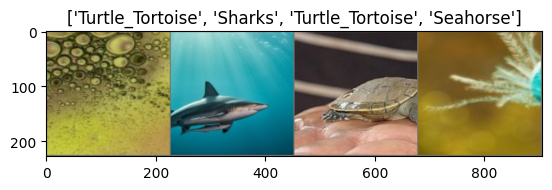

In [ ]:
def imshow(inp, title=None):
  """Imshow for Tesnor."""
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0 ,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


# Get a bach of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
        datasetloader = trainloader
        dataset_sizes = len(Train)
      else:
        model.eval()
        datasetloader = testloader
        dataset_sizes = len(Test)

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data

      for inputs, labels in datasetloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes
      epoch_acc = running_corrects.double() / dataset_sizes

      print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc:.4f}')

      # deep copy the model

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Traing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  #load best model weights

  model.load_state_dict(best_model_wts)
  return model




In [ ]:
def visualize_model (model, num_images=6):
  was_training = model.training
  model.eval()
  image_so_far =0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      output = model(inputs)
      _, preds = torch.max(output, 1)

      for j in range(inputs.size()[0]):
        image_so_far += 1
        ax = plt.subplot(num_images//2,2,image_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if image_so_far == num_images:
          model.train(mode = was_training)
          return

        model.train(mode = was_training)



## **Fine Tuning**

In [ ]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 24)

# model_ft = models.resnet18(pre_trained = True)

# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, 19)
model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


## **Train and Evaluate**

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)


Epoch 0/3
----------
train Loss:  1.5182 Acc: 0.5186
val Loss:  0.9497 Acc: 0.6937

Epoch 1/3
----------
train Loss:  1.2707 Acc: 0.6118
val Loss:  1.2402 Acc: 0.6422

Epoch 2/3
----------
train Loss:  1.1615 Acc: 0.6469
val Loss:  0.9105 Acc: 0.7096

Epoch 3/3
----------
train Loss:  1.1309 Acc: 0.6540
val Loss:  0.9948 Acc: 0.7234

Traing complete in 3m 11s
Best val Acc: 0.723432


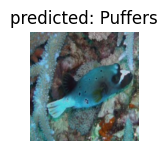

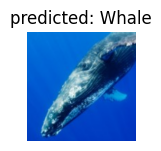

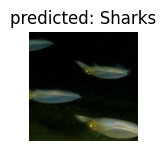

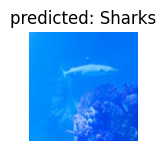

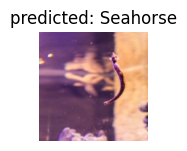

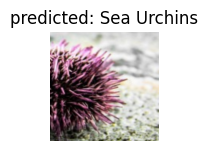

In [ ]:
visualize_model(model_ft)

In [ ]:
from PIL import Image

img = Image.open('/content/output/train/Squid/10667929816_ebee0f15e3_o.jpg')

x = test_transforms(img)

x = x.unsqueeze(0).to(device)

print(class_names[torch.argmax(model_ft(x))])




Squid
